### importing icevision for dataset loading and model training and other libraries for coco creation

In [1]:
from icevision.all import *
from lunular.data import coco
import numpy as np

import json
import os
from PIL import Image
from pycococreatortools import pycococreatortools

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /home/rave/.icevision/mmdetection_configs/mmdetection_configs-2.16.0/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17


In [2]:
model_type = models.torchvision.mask_rcnn
backbone = model_type.backbones.resnet34_fpn()

In [3]:
ml_data_path = os.path.join(os.path.abspath(os.getcwd()),"../ML/Data")

In [4]:
path = Path(ml_data_path)
codes = np.loadtxt(path/'codes-nocoincident.txt', dtype=str)

In [5]:
def get_chps(path): 
    oil_chps = np.loadtxt(path/'oil_chps.txt', dtype=str)
    density = 0
    num_oilless = density * len(oil_chps)
    oilless_chps = [chp for chp in get_image_files(path/'chp') if chp.stem not in oil_chps]
    mixed_chps = random.sample(oilless_chps,num_oilless) + [path/'chp'/(chp+'.png') for chp in oil_chps]
    return mixed_chps

def get_lbls(fn): return fn.parent.parent/"lbl_no3"/f"{fn.name}"
def splitter_func(path, fn): 
    valid_names = np.loadtxt(path/'valid_names.txt', dtype=str)
    return fn.name.rsplit('_',1)[0] in valid_names # XXX Check to make sure this should be returning True for Valid

drive_files = get_chps(path)

In [6]:
lbl_chps = [get_lbls(x) for x in get_chps(path)]

In [7]:
lcl = Path("../out_data")
path.mkdir(exist_ok=True)
modelpath = lcl

In [8]:
img_dir=f"{path}/chp"

### Making a COCO Dataset for Mask-RCNN, converting single band (assumed single instance) annotations from raster labels

In [11]:
chps = get_chps(path)

In [12]:


info = {
    "description": "CeruleanDataset V1, Binary Slick/Not Slick",
    "url": "none",
    "version": "1.0",
    "year": 2021,
    "contributor": "Skytruth",
    "date_created": "2021/11/12"
}

licenses = [
    {
        "url": "none",
        "id": 1,
        "name": "CeruleanDataset V1, Binary Slick/Not Slick"
    }
]
categories = [{"supercategory":"slick", "id":1,"name":"oil_slick"}]

coco_output = {
    "info": info,
    "licenses": licenses,
    "images": [],
    "annotations": [],
    "categories": categories
}

image_id = 1
segmentation_id = 1

images_d = []

# filter for jpeg images
for i,n in enumerate(chps):
    images_d.append({"file_name": str(n), "height": 512, "width": 512, "id":i})

    # go through each label image to extract annotation
    image = Image.open(str(n))
    image_info = pycococreatortools.create_image_info(
        image_id, os.path.basename(str(n)), image.size)
    coco_output["images"].append(image_info)

    annotation_filename = str(lbl_chps[i])
    arr = np.array(Image.open(annotation_filename))
    if 1 in arr:
        class_id = 1
        category_info = {"id":class_id,"is_crowd":True}
    else:
        class_id = 0
        category_info = {"id":class_id,"is_crowd":False}
    binary_mask = np.asarray(Image.open(annotation_filename)).astype(np.uint8)

    annotation_info = pycococreatortools.create_annotation_info(
        segmentation_id, image_id, category_info, binary_mask,
        image.size, tolerance=0)

    if annotation_info is not None:
        coco_output["annotations"].append(annotation_info)

    segmentation_id = segmentation_id + 1

    image_id = image_id + 1

with open('{}/instances_slick_train.json'.format(path), 'w') as output_json_file:
    json.dump(coco_output, output_json_file)


In [14]:
class_map = ClassMap(["oil_slick"])
class_map # https://airctic.github.io/icedata/dataset_voc_nb/#define-class_map

<ClassMap: {'background': 0, 'oil_slick': 1}>

In [15]:
parser = parsers.COCOMaskParser(f'{path}/instances_slick_train.json', img_dir)

### Parsing works! we're just trying to test if this trains and evaluates correctly, it's ok if many of these instances don't look like instances for now since the dataset was made for semantic segmentation

It's possible icevision is filtering out all negative samples here during autofixing, which we can check. Our most useful samples will include non-background class hard negatives and positives anyway

  0%|          | 0/434 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/434 [00:00<?, ?it/s]

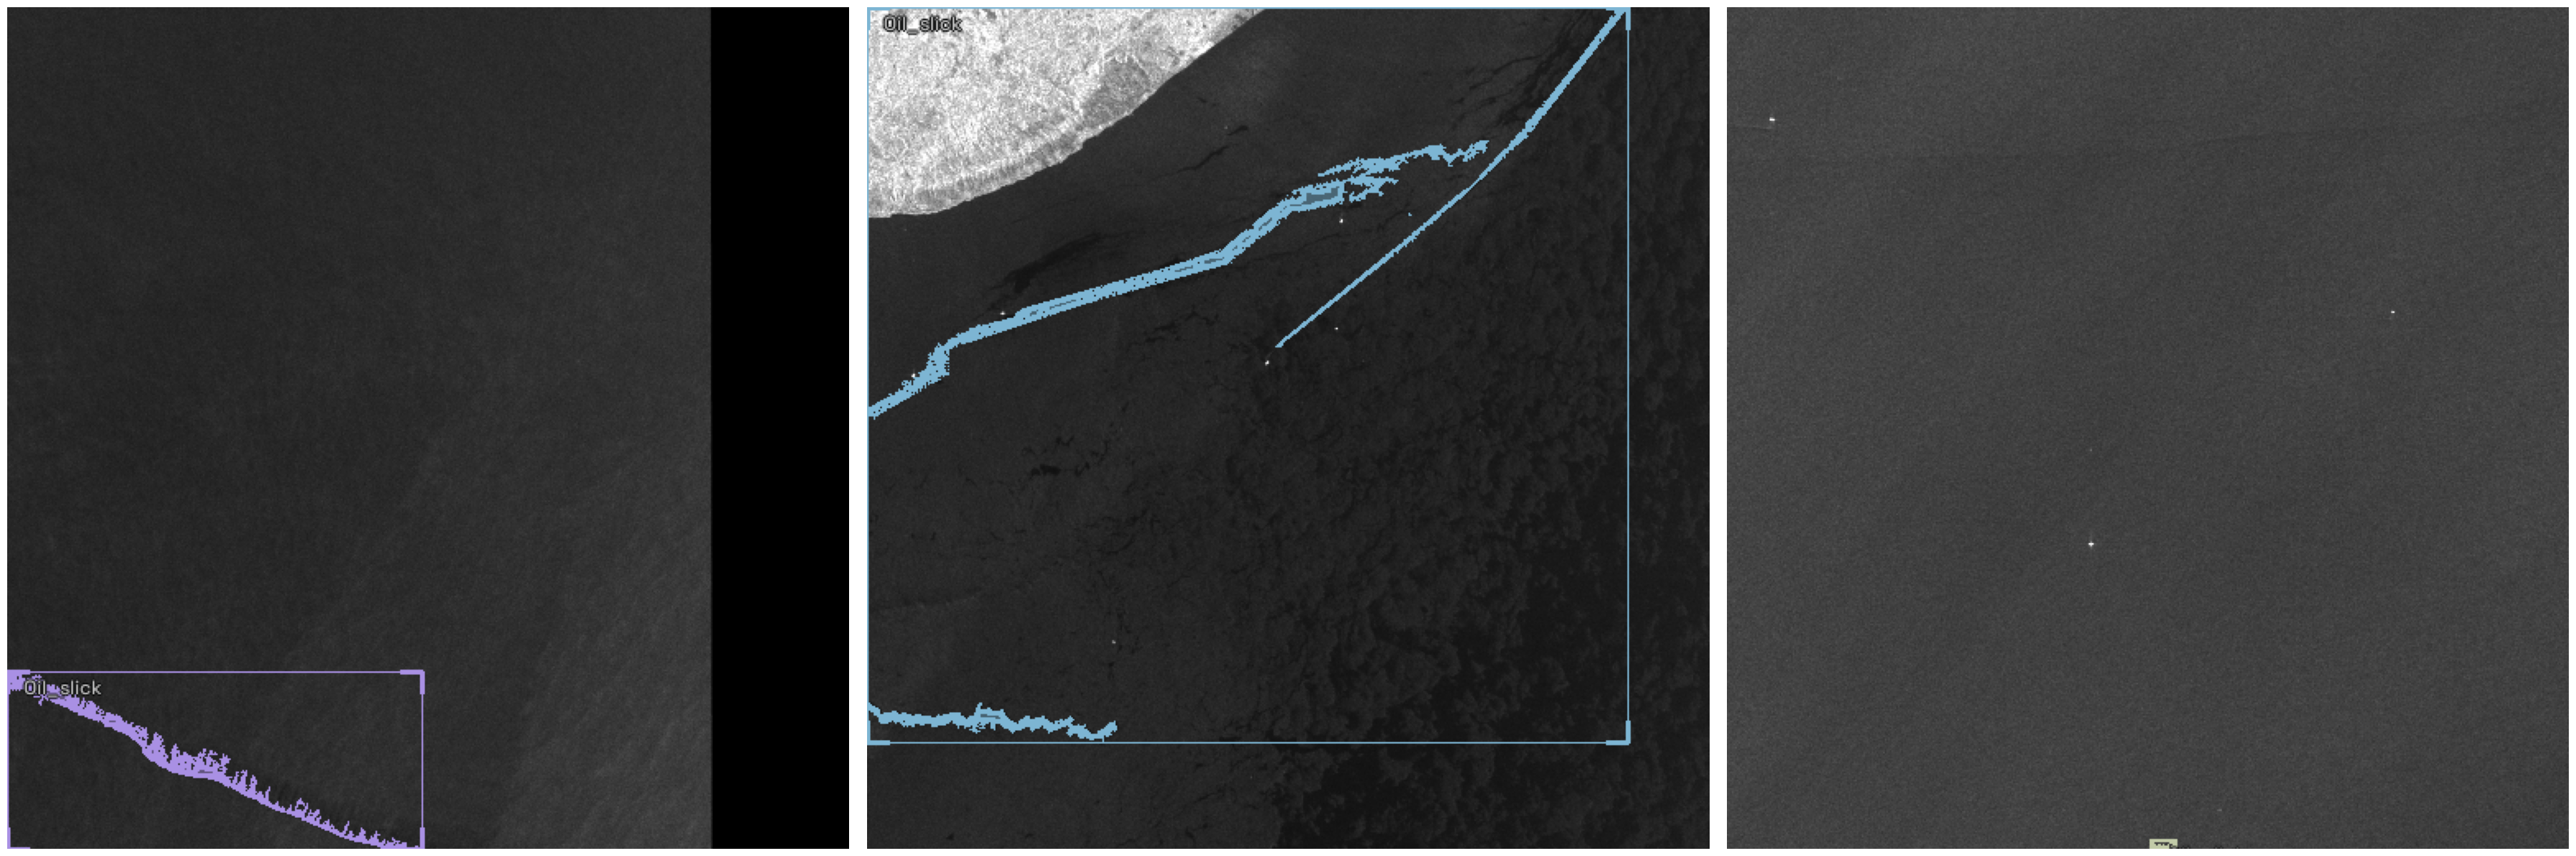

In [16]:
# Parse the annotations to create the train and validation records
train_records, valid_records = parser.parse()
show_records(train_records[:3], ncols=3, class_map=class_map)
plt.savefig("train_slick_examples.png")

sourced from: https://airctic.com/0.8.1/getting_started_instance_segmentation/

In [17]:
train_ds = Dataset(train_records)
valid_ds = Dataset(valid_records)

train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=6, shuffle=True) # adjust num_workers for your processor count
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=6, shuffle=False)

model = model_type.model(backbone=backbone(pretrained=False), num_classes=len(parser.class_map))

metrics = [COCOMetric(metric_type=COCOMetricType.mask)]

learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

lr = learn.lr_find()

In [23]:
lr

SuggestedLRs(valley=3.0199516913853586e-05)

In [24]:
learn.fine_tune(5,3.6e-5)

### temporary uh oh, for some reason eval seems to be running on a three band combination

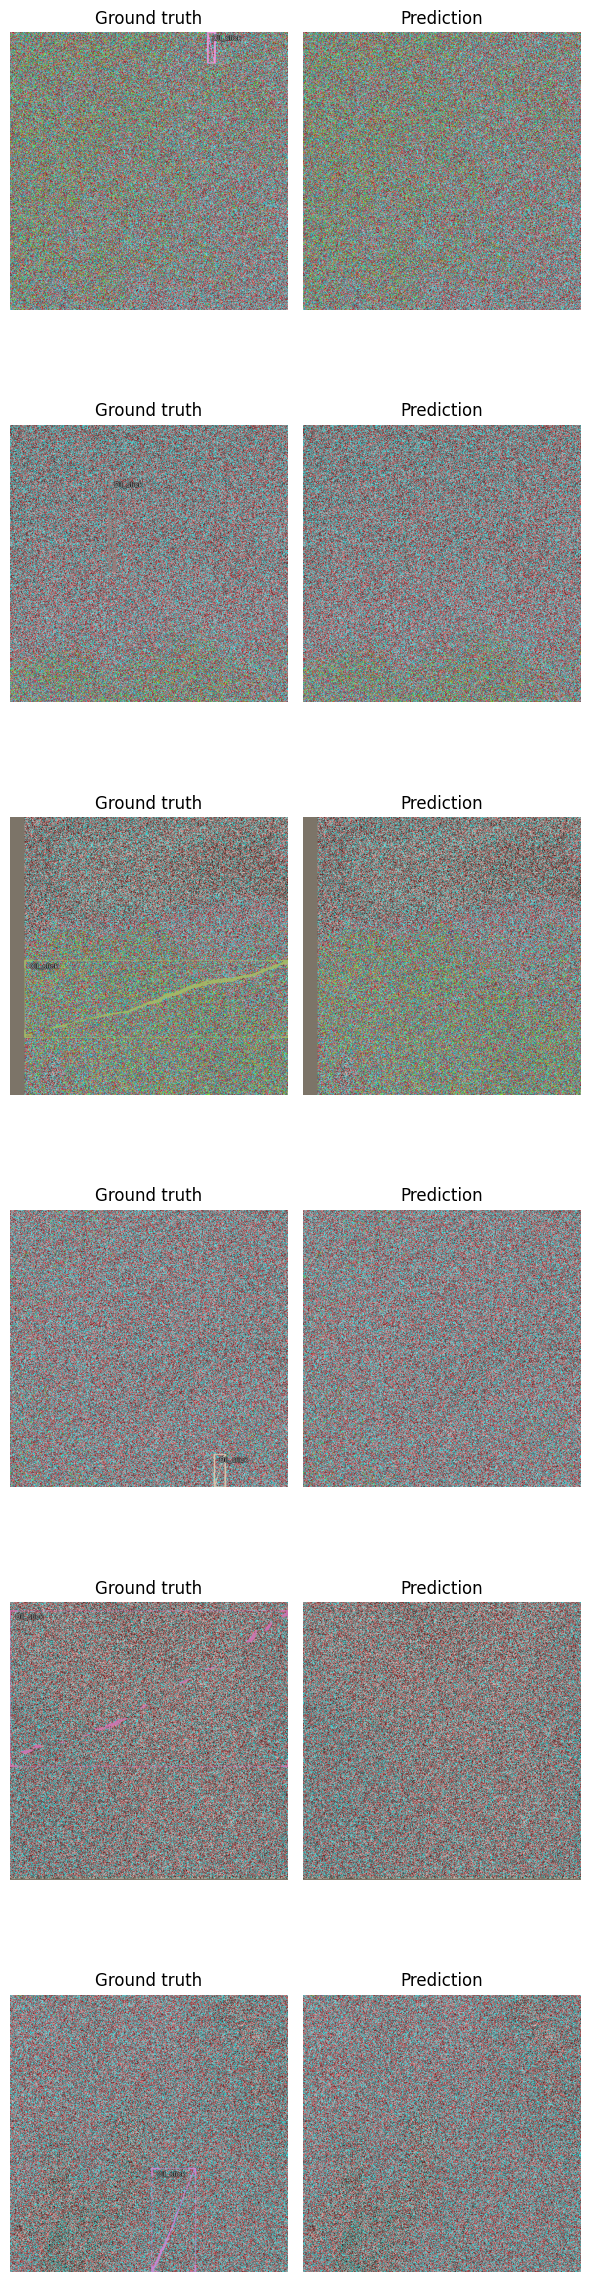

<Figure size 640x480 with 0 Axes>

In [26]:
model_type.show_results(model, valid_ds, detection_threshold=.5)
plt.savefig("inference_results.png")

In [75]:
tfms.transform.Transform

Init signature: tfms.transform.Transform()
Docstring:     
Helper class that provides a standard way to create an ABC using
inheritance.
Source:        
class Transform(ABC):
    def __call__(self, record: BaseRecord):
        # TODO: this assumes record is already loaded and copied
        # which is generally true
        return self.apply(record)

    @abstractmethod
    def apply(self, record: BaseRecord) -> BaseRecord:
        """Apply the transform
        Returns:
              dict: Modified values, the keys of the dictionary should have the same
              names as the keys received by this function
        """
File:           ~/miniconda3/envs/icevision/lib/python3.8/site-packages/icevision/tfms/transform.py
Type:           ABCMeta
Subclasses:     Adapter


In [74]:
size = 64 # Progressive resizing could happen here
augs = aug_transforms(flip_vert=True, max_warp=0.1, size=size)

NameError: name 'aug_transforms' is not defined

In [11]:
model_type??

Type:        module
String form: <module 'icevision.models.torchvision.mask_rcnn' from '/home/rave/miniconda3/envs/icevision/lib/python3.8/site-packages/icevision/models/torchvision/mask_rcnn/__init__.py'>
File:        ~/miniconda3/envs/icevision/lib/python3.8/site-packages/icevision/models/torchvision/mask_rcnn/__init__.py
Source:     
from icevision.models.torchvision.loss_fn import *

from icevision.models.torchvision.mask_rcnn import backbones
from icevision.models.torchvision.mask_rcnn.dataloaders import *
from icevision.models.torchvision.mask_rcnn.model import *
from icevision.models.torchvision.mask_rcnn.prediction import *
from icevision.models.torchvision.mask_rcnn.show_results import *
from icevision.models.torchvision.mask_rcnn.show_batch import *

# Soft dependencies
from icevision.soft_dependencies import SoftDependencies

if SoftDependencies.fastai:
    import icevision.models.torchvision.mask_rcnn.fastai

if SoftDependencies.pytorch_lightning:
    import icevision.model